In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

In [15]:
data = pd.read_csv('spambase.data', header=None) .fillna(0) .to_numpy()

In [7]:
with open('spambase.names') as f:
    print(f.read())

| SPAM E-MAIL DATABASE ATTRIBUTES (in .names format)
|
| 48 continuous real [0,100] attributes of type word_freq_WORD 
| = percentage of words in the e-mail that match WORD,
| i.e. 100 * (number of times the WORD appears in the e-mail) / 
| total number of words in e-mail.  A "word" in this case is any 
| string of alphanumeric characters bounded by non-alphanumeric 
| characters or end-of-string.
|
| 6 continuous real [0,100] attributes of type char_freq_CHAR
| = percentage of characters in the e-mail that match CHAR,
| i.e. 100 * (number of CHAR occurences) / total characters in e-mail
|
| 1 continuous real [1,...] attribute of type capital_run_length_average
| = average length of uninterrupted sequences of capital letters
|
| 1 continuous integer [1,...] attribute of type capital_run_length_longest
| = length of longest uninterrupted sequence of capital letters
|
| 1 continuous integer [1,...] attribute of type capital_run_length_total
| = sum of length of uninterrupted sequences of

In [165]:
# Split data into training and test sets
train, test = train_test_split(data, test_size=0.2, train_size=0.8, shuffle=True)

In [166]:
X_train = train[:,:-1]
y_train = train[:,-1]
X_test = test[:,:-1]
y_test = test[:,-1]

In [167]:
y_train.shape

(3680,)

In [ ]:
# CART
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

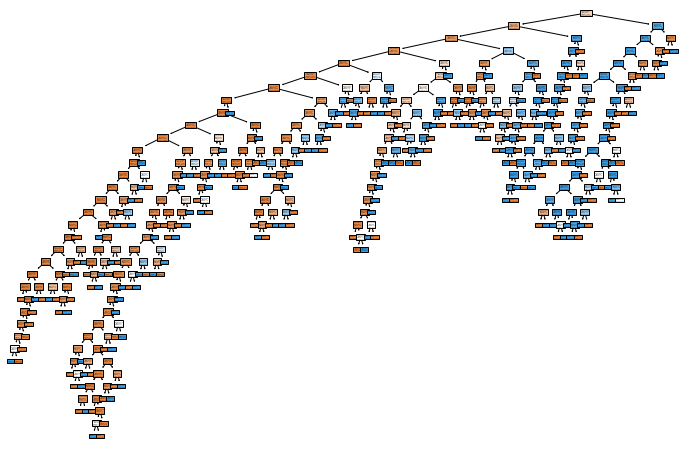

In [190]:
fig = plt.figure(figsize=(12,8))
plot_tree(clf, filled=True)
plt.show()

In [169]:
# CART error rate
cart_error = 1 - clf.score(X_test, y_test)

In [170]:
# Random forest
n_trees = np.arange(1,301)
clf_rf = RandomForestClassifier(oob_score=True)
clf_rf.fit(X_train, y_train)
clf_rf.oob_score_

0.9529891304347826

In [171]:
errors = []
for t in n_trees:
    clf_rf = RandomForestClassifier(n_estimators = t)
    clf_rf.fit(X_train,y_train)
    errors.append(1 - clf_rf.score(X_test, y_test))

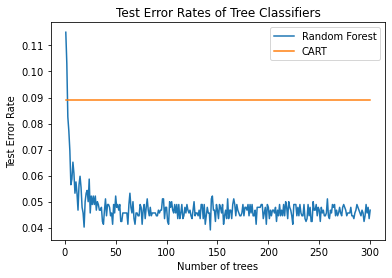

In [191]:
# Plot test error rates
fig, ax = plt.subplots()
ax.plot(n_trees,errors,label='Random Forest')
ax.plot(n_trees,cart_error*np.ones(len(n_trees)),label='CART')
ax.set_xlabel('Number of trees')
ax.set_ylabel('Test Error Rate')
ax.set_title('Test Error Rates of Tree Classifiers')
ax.legend()
plt.show() # Looks like the default value of 100 trees is a fine choice

In [173]:
# Test number of features to split; plot OOB error and test error
OOB_errors = []
test_errors = []
n_features = np.arange(1,51)

for f in n_features:
    clf_rf = RandomForestClassifier(n_estimators=100, max_features=f, oob_score=True)
    clf_rf.fit(X_train, y_train)
    OOB_errors.append(1- clf_rf.oob_score_)
    test_errors.append(1 - clf_rf.score(X_test, y_test))

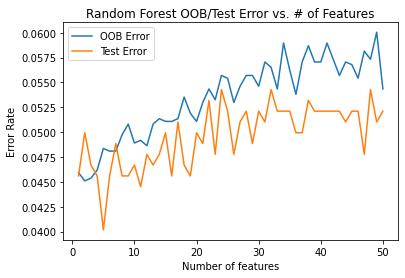

In [192]:
fig, ax = plt.subplots()
ax.plot(n_features, OOB_errors, label="OOB Error")
ax.plot(n_features, test_errors, label="Test Error")
ax.set_xlabel('Number of features')
ax.set_ylabel('Error Rate')
ax.set_title('Random Forest OOB/Test Error vs. # of Features')
ax.legend()
plt.show()

In [175]:
# RBF SVM
X_train_0 = X_train[np.where(y_train == 0)]
y_train_0 = y_train[np.where(y_train == 0)]

# Scale features for training and test data
scaler = preprocessing.StandardScaler().fit(X_train_0)
X_train_0_scaled = scaler.transform(X_train_0)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

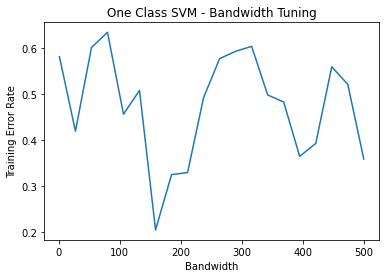

In [194]:
gammas = np.linspace(1,500,20)
g_errors = []

for g in gammas:
    clf_svm = OneClassSVM(kernel='rbf', gamma=g).fit(X_train_0_scaled)
    results = clf_svm.predict(X_train_0_scaled) # -1 = no spam, 1 = spam
    results[np.where(results == 1)[0]] = 0 # Adjust labels to match training data
    results[np.where(results == -1)[0]] = 1
    
    n_correct = sum([1 for i in range(len(results)) if results[i] == y_train_0[i]])
    
    """for i in range(len(results)):
        if results[i] == y_train_0[i]:
            n_correct += 1"""
            
    g_errors.append(1 - n_correct/len(y_train_0))

plt.plot(gammas,g_errors)
plt.xlabel('Bandwidth')
plt.ylabel('Training Error Rate')
plt.title('One Class SVM - Bandwidth Tuning')
plt.show()

In [183]:
# Optimal bandwidth
g_opt = gammas[np.where(g_errors == np.min(g_errors))[0][0]]

In [184]:
clf_svm = OneClassSVM(kernel='rbf', gamma=g_opt).fit(X_train_0_scaled)
results = clf_svm.predict(X_test_scaled) # -1 = spam, 1 = no spam
results[np.where(results == 1)[0]] = 0 # Adjust labels to match training data
results[np.where(results == -1)[0]] = 1
n_correct = sum([1 for i in range(len(results)) if results[i] == y_test[i]])
print('Error rate: {}'.format(1 - n_correct/len(y_test)))

Error rate: 0.5906623235613464
